# Workshop

Veri setinin temel amacı, bir **PMSM**(sabit mıknatıslı senkron motor)'nin stator ve rotor sıcaklıklarını gerçek zamanlı olarak modelleyebilmektir. 
Elektrikli çekiş tahrikinin karmaşık yapısı nedeniyle, rotor sıcaklıkları için termal sensörlerle doğrudan ölçüm mümkün değildir ve hatta stator sıcaklıkları, sensör kesintisi ve hatta sadece bozulma durumunda bile yedekli modelleme olmadan düzgün bir şekilde yönetilemez. 

Tüm kayıtlar 2 Hz'de örneklenmiştir. Veri seti, birbirinden "profil_id" sütunuyla ayırt edilebilen birden fazla ölçüm oturumundan oluşur. Bir ölçüm oturumu yaklaşık bir ila altı saat arasındadır.

Iq ve Id, armatür akımının fazör bileşenleridir. 

**Iq bileşeni**, üretilen armatür voltajıyla aynı fazdadır ve sabit mıknatıs alan kutupları arasındaki boşluğa ortalanmış bir manyetik akı üretir. 

**Id bileşeni** kalıcı mıknatıs kutuplarına odaklanan bir manyetik akı üretir.

**PMSM:** permanent magnet synchronous motor (sabit mıknatıslı senkron motor)

### Kolonlar ve Açıklamaları:

- **ambient:** Statorun yakınına yerleştirilmiş bir termal sensör tarafından ölçülen ortam sıcaklığı.
- **coolant:** Soğutucu sıcaklığı. Motor su soğutmalıdır. Çıkışta ölçüm alınır.
- **u_d:** d-elemanın gerilimi
- **u_q:** g-elemanın gerilimi
- **motor_speed:** motor hızı
- **torque:** Akımdan kaynaklanan tork
- **i_d:** d-elemanın akımı
- **i_q:** q-elemanın akımı
- **pm:** kızılötesi termografi ünitesi ile ölçülen rotor sıcaklığını temsil eden sabit mıknatıs yüzey sıcaklığı
- **stator_yoke:** Termal sensör ile ölçülen stator manşonu sıcaklığı

### Tahmin edilecek hedefler (Targets):
 - stator_yoke
 - stator_winding
 - stator_tooth
 - pm
 
### Bağımlı değikenler (Features):
Kalan tüm kolonlar kullanıbilir Torque hariç.
Tork, saha uygulamalarında güvenilir bir şekilde ölçülemeyen bir niceliktir, bu yüzden bu özellik bu görevde ihmal edilecektir.

### Değerlendirme
Mümkün olduğunda az hata değerine sahip iyi tahmin eden bir model geliştirmek.

Seçilen hedef kolonun standart sapmasından daha düşük ortalama mutlak değer hatası geliştirmelisiniz

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data = pd.read_csv("datasets/pmsm_temps.csv")

In [3]:
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [4]:
data["profile_id"].value_counts()[:3]

20    43970
4     33423
Name: profile_id, dtype: int64

In [5]:
data_20 = data[data["profile_id"] == 20]

In [6]:
data_20.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
33423,-1.908649,-1.079592,0.323421,-1.294816,-1.222431,-0.242639,1.029656,-0.245912,-2.484866,-1.811525,-2.055589,-1.997400,20
33424,-1.945673,-1.079477,0.318831,-1.293665,-1.222432,-0.240214,1.029574,-0.245876,-2.484019,-1.811462,-2.055858,-1.996591,20
33425,-1.946597,-1.079168,0.319580,-1.297363,-1.222431,-0.239513,1.029505,-0.245856,-2.484323,-1.811073,-2.056149,-1.995407,20
33426,-1.947213,-1.077655,0.321388,-1.295731,-1.222431,-0.238094,1.033528,-0.247344,-2.484937,-1.811298,-2.056193,-1.995178,20
33427,-1.952527,-1.075799,0.321497,-1.298276,-1.222431,-0.237660,1.032298,-0.246866,-2.485552,-1.810891,-2.056976,-1.994601,20


In [7]:
drop_targets = ["profile_id", "stator_yoke", "stator_winding", "stator_tooth", "torque"]
target = "pm"

In [8]:
data_20_reset = data_20.reset_index(drop=True)
data_dropped = data_20_reset.drop(labels=drop_targets, axis=1)
data_dropped.head()

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm
0,-1.908649,-1.079592,0.323421,-1.294816,-1.222431,1.029656,-0.245912,-2.484866
1,-1.945673,-1.079477,0.318831,-1.293665,-1.222432,1.029574,-0.245876,-2.484019
2,-1.946597,-1.079168,0.319580,-1.297363,-1.222431,1.029505,-0.245856,-2.484323
3,-1.947213,-1.077655,0.321388,-1.295731,-1.222431,1.033528,-0.247344,-2.484937
4,-1.952527,-1.075799,0.321497,-1.298276,-1.222431,1.032298,-0.246866,-2.485552


In [9]:
data_dropped.shape

(43970, 8)

In [10]:
corr = data_dropped.corr()

In [11]:
corr["pm"]

ambient        0.574095
coolant        0.237368
u_d           -0.580232
u_q           -0.204726
motor_speed    0.444886
i_d           -0.615226
i_q            0.219197
pm             1.000000
Name: pm, dtype: float64

In [12]:
corr["pm"].abs()

ambient        0.574095
coolant        0.237368
u_d            0.580232
u_q            0.204726
motor_speed    0.444886
i_d            0.615226
i_q            0.219197
pm             1.000000
Name: pm, dtype: float64

In [13]:
corr["pm"].abs().sort_values(ascending=False)

pm             1.000000
i_d            0.615226
u_d            0.580232
ambient        0.574095
motor_speed    0.444886
coolant        0.237368
i_q            0.219197
u_q            0.204726
Name: pm, dtype: float64

In [14]:
corr["pm"].abs().sort_values(ascending=False)

pm             1.000000
i_d            0.615226
u_d            0.580232
ambient        0.574095
motor_speed    0.444886
coolant        0.237368
i_q            0.219197
u_q            0.204726
Name: pm, dtype: float64

In [15]:
usefull_columns = list(corr["pm"].abs().sort_values(ascending=False)[:7].index)
usefull_columns

['pm', 'i_d', 'u_d', 'ambient', 'motor_speed', 'coolant', 'i_q']

In [16]:
data_usefull = data_dropped[usefull_columns]
data_usefull.head()

,pm,i_d,u_d,ambient,motor_speed,coolant,i_q
0,-2.484866,1.029656,0.323421,-1.908649,-1.222431,-1.079592,-0.245912
1,-2.484019,1.029574,0.318831,-1.945673,-1.222432,-1.079477,-0.245876
2,-2.484323,1.029505,0.319580,-1.946597,-1.222431,-1.079168,-0.245856
3,-2.484937,1.033528,0.321388,-1.947213,-1.222431,-1.077655,-0.247344
4,-2.485552,1.032298,0.321497,-1.952527,-1.222431,-1.075799,-0.246866


In [17]:
corr_usefull = data_usefull.corr()

In [18]:
corr_usefull

,pm,i_d,u_d,ambient,motor_speed,coolant,i_q
pm,1.000000,-0.615226,-0.580232,0.574095,0.444886,0.237368,0.219197
i_d,-0.615226,1.000000,0.891190,-0.101042,-0.786186,0.126580,-0.342511
u_d,-0.580232,0.891190,1.000000,-0.116566,-0.662405,-0.001174,-0.532353
ambient,0.574095,-0.101042,-0.116566,1.000000,0.040813,0.732546,-0.032948
motor_speed,0.444886,-0.786186,-0.662405,0.040813,1.000000,-0.110457,-0.070917
coolant,0.237368,0.126580,-0.001174,0.732546,-0.110457,1.000000,-0.034647
i_q,0.219197,-0.342511,-0.532353,-0.032948,-0.070917,-0.034647,1.000000


<AxesSubplot:>

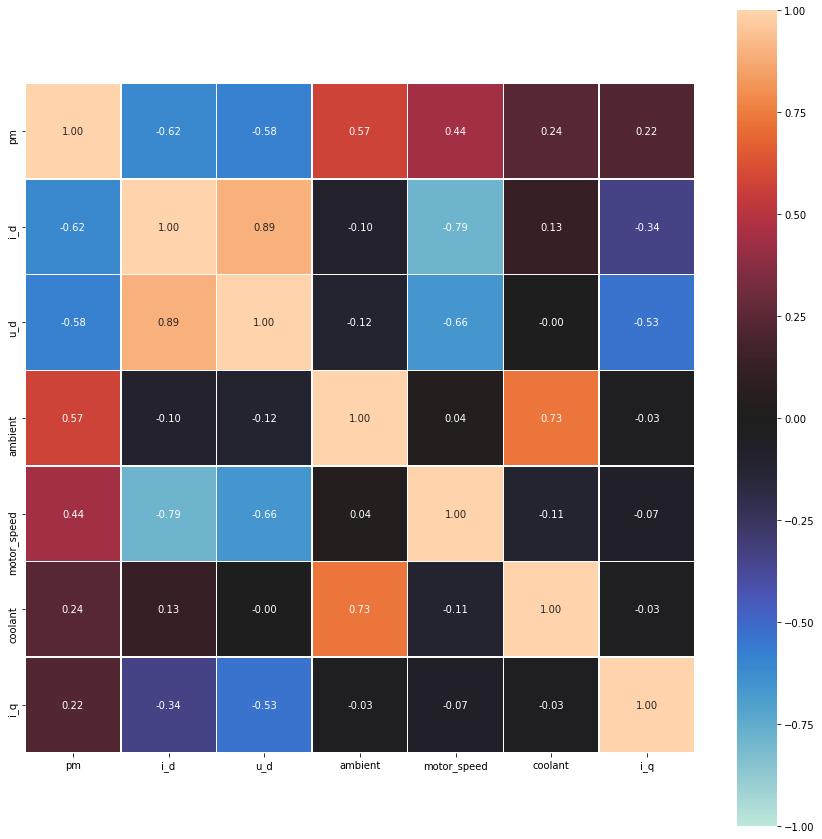

In [19]:
plt.figure(figsize=(15, 15))
sns.heatmap(data=corr_usefull, vmax=1.0, vmin=-1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True)

In [20]:
import xgboost as xgb

In [21]:
y = data_usefull[["pm"]]
x = data_usefull.drop(labels=["pm"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.95)

In [22]:
print(x_train.shape)
print(x_test.shape)

(41771, 6)
(2199, 6)


In [23]:
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                        n_estimators = 30, 
                        max_depth=10, 
                        learning_rate=0.6) 

model.fit(x_train, y_train)  
pred = model.predict(x_test)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("MSE: ", mean_squared_error(y_test, pred))
print()
print("MAE: ", mean_absolute_error(y_test, pred))
print("STD: ", y_test.std())

MSE:  0.0023929085798001263

MAE:  0.027284355279179214
STD:  pm    1.198202
dtype: float64


In [25]:
results = pd.concat([pd.Series(y_test["pm"].values), pd.Series(pred)], axis=1)
results.columns = ["y_true", "preds"]
results_sorted = results.sort_values("y_true")
results_reset = results_sorted.reset_index()

In [26]:
results_reset.head()

,index,y_true,preds
0,639,-2.479409,-2.463423
1,1995,-2.446818,-2.427687
2,1272,-2.437738,-2.404782
3,621,-2.433499,-2.404782
4,2153,-2.426055,-2.417414


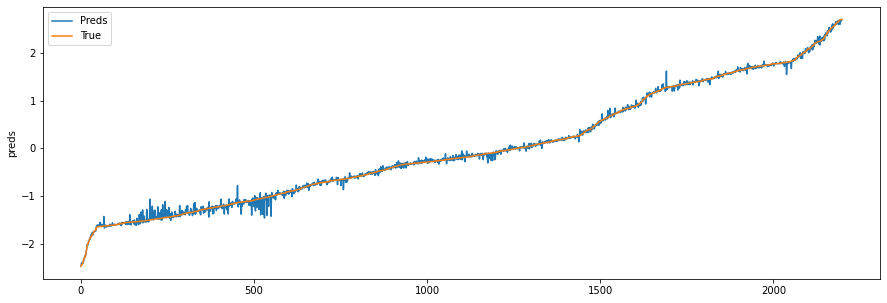

In [27]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=results_reset, y="preds", x=results_reset.index, label="Preds")
sns.lineplot(data=results_reset, y="y_true", x=results_reset.index, label="True")
plt.legend()

<BarContainer object of 6 artists>

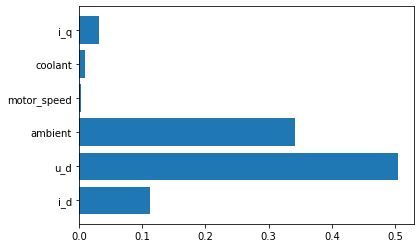

In [28]:
plt.barh(x_train.columns, model.feature_importances_)

In [29]:
sort_index = model.feature_importances_.argsort()
sort_index

array([3, 4, 5, 0, 2, 1])

In [30]:
model.feature_importances_[sort_index]

array([0.00254442, 0.0087898 , 0.03098504, 0.11175258, 0.34164956,
       0.5042786 ], dtype=float32)

<BarContainer object of 6 artists>

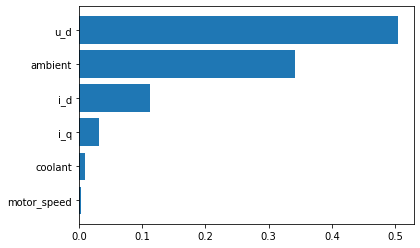

In [31]:
plt.barh(x_train.columns[sort_index], model.feature_importances_[sort_index])